In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [1]:
from tensorboardX import SummaryWriter
from tqdm import tqdm
import gc
from copy import deepcopy
from gym_multi_point import MultiPointEnv

import torch
import numpy as np
from torch import nn
import math
from models import *   
from train_multi_single_random_dataset_v2 import *
from core import generate_default_model_name

import scipy
from random import shuffle
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from collections import defaultdict

# inference

In [2]:
Env = MultiPointEnv
env = MultiPointEnv(num_agents=3, mode='barrier', PROB=(0,0.1), SIZE=(8,8))
name_dict = generate_default_model_name(Env)
bnn = OriginGNN(HIDDEN_SIZE, 3, keys=['agent', 'obstacle'])
bnn.to(device)
bnn.load_state_dict(torch.load('model_gnn/good_models/dbgnn_MultiPointEnv_yes_obstacle_best.pt', map_location=device))
bnn.eval()
print(bnn)

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch_geometric/nn/conv/hetero_conv.py:53: UserWarning: There exist node types ({'obstacle'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


OriginGNN(
  (embed): LazyLinear(in_features=0, out_features=128, bias=False)
  (edge_embed): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (convs): ModuleList(
    (0): HeteroConv(num_relations=2)
    (1): HeteroConv(num_relations=2)
    (2): HeteroConv(num_relations=2)
  )
  (field): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


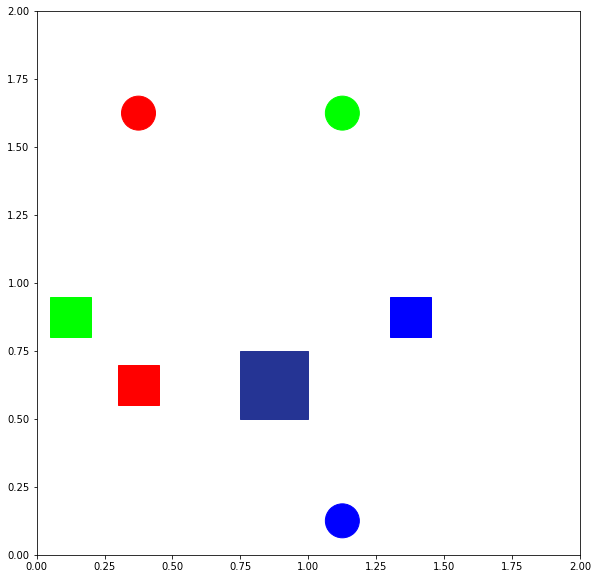

In [3]:
%notebook widget
import matplotlib.pyplot as plt
env = MultiPointEnv(num_agents=3, mode='barrier', PROB=(0,0.1), SIZE=(8,8))
plt.imshow(env._render())
plt.show()

In [127]:
env._get_obs(mode='barrier')

{'x': tensor([[2.5000, 0.5000],
         [2.5000, 3.5000],
         [2.5000, 6.5000],
         [3.5000, 0.5000],
         [3.5000, 1.5000],
         [4.5000, 2.5000],
         [5.5000, 1.5000],
         [7.5000, 4.5000],
         [0.5000, 5.5000],
         [1.5000, 6.5000],
         [6.5000, 6.5000]]),
 'edge_index': tensor([[ 1,  2,  2,  7,  8,  8,  9,  9, 10],
         [ 8,  8,  9, 10,  8,  9,  8,  9, 10]]),
 'label': tensor([[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.]]),
 'goal': tensor([[5.5000, 0.5000],
         [6.5000, 2.5000],
         [5.5000, 6.5000]])}

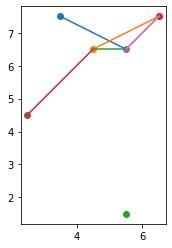

In [132]:
plt.clf()
plt.close('all')
# env._render()
x = env._get_obs(mode='barrier')['x'].data.cpu().numpy()
for node in x:
    plt.scatter(node[0], node[1])
edges = env._get_obs(mode='barrier')['edge_index'].data.cpu().numpy().T
for edge in edges:
    a, b = edge
    plt.plot([x[a][0], x[b][0]], [x[a][1], x[b][1]])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### visualization on traj

In [10]:
NUM_AGENTS = 3
MAP_SIZE = 4
OBSTACLE_DENSITY = 0.
THRESHOLD = 1e-2

-----------------------------------------------------------------------------


RuntimeError: mat1 dim 1 must match mat2 dim 0

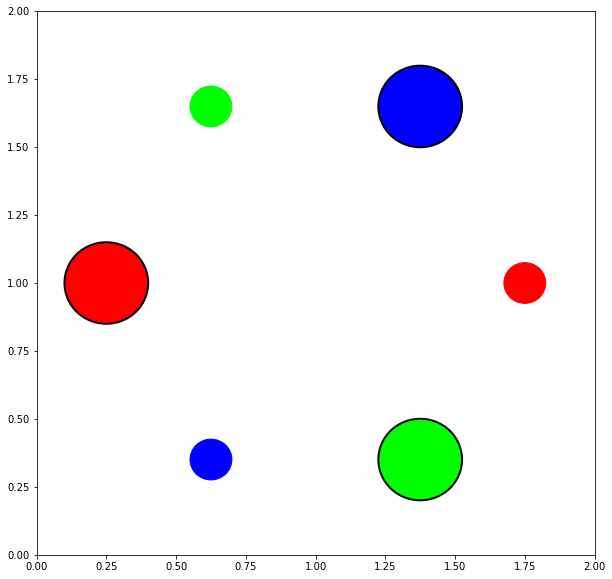

In [20]:
from gym_multi_point import MultiPointEnv
from tqdm import tqdm
from collections import defaultdict
from PIL import Image
import random

# bnn = HeteroGNN(HIDDEN_SIZE, 3, keys=['agent', 'obstacle'])
# bnn.to(device)

# name_dict = generate_default_model_name(Env)
# print(bnn.load_state_dict(torch.load(name_dict['db'].replace('.pt', '_current.pt'), map_location=device)))  # 
# bnn.eval()

Env = MultiPointEnv
env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))

@torch.no_grad()
def infer(env, verbose=True, seed=0):
    
    global bnn
    
    print('-----------------------------------------------------------------------------')
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    max_episode_length = 256

    total_trans=0; n_danger=0; threshold=THRESHOLD; no_feasible=0; collided=np.zeros(env.num_agents).astype(bool);gifs = [env._render()]

    while True:
        o = env._get_obs()
        a_all = np.random.uniform(-1, 1, size=(env.num_agents, n_candidates, env.action_dim))
        a_refines, bvalues = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)

        dists = []
        next_states = env.world.agents.reshape(env.num_agents, 1, -1)+0.3*a_refines
        dists = np.linalg.norm(next_states-env.world.agent_goals.reshape(env.num_agents, 1, -1), axis=-1)
        a = np.zeros((env.num_agents, env.action_dim))
        v = np.zeros(env.num_agents)
        for agent_id, a_refine, bvalue, dist in zip(np.arange(env.num_agents), a_refines, bvalues, dists):
            if np.any(bvalue>threshold):
                for a_idx in np.argsort(dist):
                    if bvalue[a_idx] > threshold:
                        a[agent_id] = a_refine[a_idx]
                        v[agent_id] = bvalue[a_idx]
                        break
            else:
                no_feasible += 1
                a[agent_id] = a_refine[np.argmax(bvalue)]
                v[agent_id] = bvalue[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)

        prev_danger = info['prev_danger'].bool().data.cpu().numpy()
        next_danger = info['next_danger'].bool().data.cpu().numpy()
        if np.any(next_danger):
            collided = collided | next_danger
        if verbose:
            print(bvalues.min(axis=-1), bvalues.max(axis=-1), v, next_danger)

        total_trans += 1
        gifs.append(env._render())

        if done or (total_trans >= max_episode_length):
            break

    return gifs, collided, done

def save_gif(gifs, name="play.gif"):
    a_frames = []
    for img in gifs:
        a_frames.append(np.asarray(img))
    a_frames = np.stack(a_frames)
    ims = [Image.fromarray(a_frame) for a_frame in a_frames]
    ims[0].save(name, save_all=True, append_images=ims[1:], loop=0, duration=10)

env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
half_size = MAP_SIZE / 2
env.world.agents = np.array([[half_size+(half_size-0.5)*np.cos(a), half_size+(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
env.world.agent_goals = np.array([[half_size-(half_size-0.5)*np.cos(a), half_size-(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
env.world.obstacles = []
gifs, collided, done = infer(env)
save_gif(gifs)
collided, done

HeteroData(
  agent={ x=[1, 1] },
  obstacle={ x=[1, 1] },
  goal={ x=[1, 1] },
  (agent, a_near_a, agent)={
    edge_index=[2, 0],
    edge_attr=[0, 2]
  },
  (obstacle, o_near_a, agent)={
    edge_index=[2, 0],
    edge_attr=[0, 2]
  },
  (goal, toward, agent)={
    edge_index=[2, 1],
    edge_attr=[1, 2]
  }
)

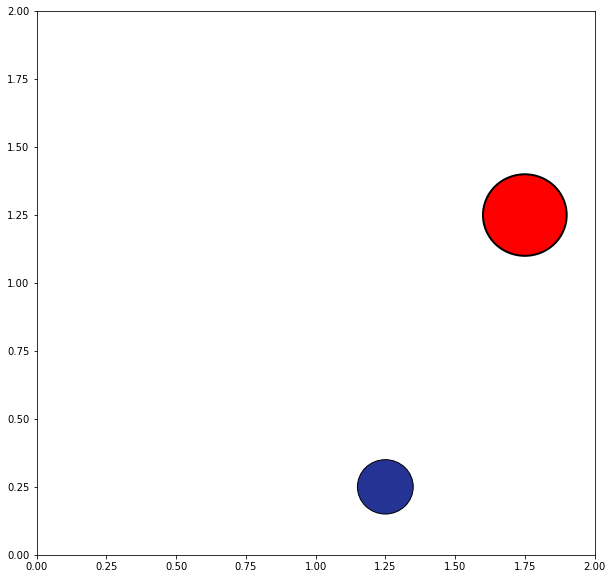

In [6]:
env = MultiPointEnv(num_agents=1, mode='barrier', PROB=(0.1,0.1), SIZE=(MAP_SIZE,MAP_SIZE))
data = env._get_obs()
env._render()
data

In [82]:
env.world.obstacles, env.world.agents

(array([[1.5, 3.5]]), array([[0.5, 2.5]]))

[0.03495593 0.0921743  0.08675359] [0.150012   0.16564529 0.17335513] [0.10066635 0.11631488 0.10053822] [False False False]
[0.05476697 0.00839909 0.09602688] [0.15757684 0.16526942 0.17584117] [0.10222574 0.11267544 0.1298798 ] [False False False]
[ 0.06042346  0.02709736 -0.00723505] [0.16519473 0.17801087 0.16840132] [0.10031396 0.11010844 0.11204965] [False False  True]
[ 0.0611678   0.09600915 -0.07481262] [0.16762832 0.17823021 0.1555355 ] [0.10100352 0.13529602 0.11442074] [False False  True]
[ 0.05158569  0.0918406  -0.04805389] [0.1705267  0.16723302 0.15321583] [0.10360438 0.13142258 0.11304494] [False False False]
[0.07741783 0.03054174 0.08150393] [0.16743793 0.16783604 0.17185186] [0.12606765 0.11273376 0.14210661] [False False False]
[0.07810363 0.01831811 0.08653377] [0.16977061 0.16656855 0.1735618 ] [0.147438   0.14357631 0.14691973] [False False False]


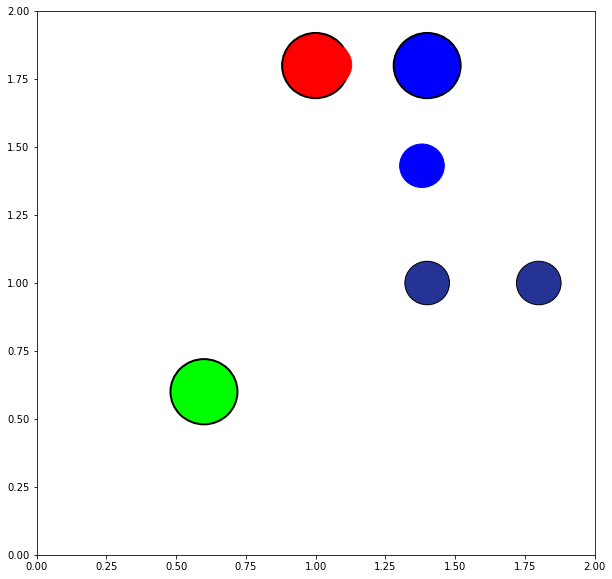

In [26]:
env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(dataset[6])
gifs, collided, done = infer(env, verbose=True)

In [2]:
from tqdm import tqdm

NUM_AGENTS, MAP_SIZE, OBSTACLE_DENSITY = 30, 7, 0

# generate training data
dataset = []
for _ in tqdm(range(100)):
    while True:
        env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
        if (np.linalg.norm(env.world.agents - env.world.agent_goals, axis=-1).min() > 2):
            break    
    dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


In [8]:
import pickle
with open('dataset/'+Env.__name__+'_test'+'.pkl', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
bnn = OriginGNN(HIDDEN_SIZE, 3, keys=['agent', 'obstacle'])
bnn.load_state_dict(torch.load('model_gnn/good_models/dbgnn_MultiPointEnv_yes_obstacle_best.pt', map_location=device))   
bnn.to(device)
'model_gnn/good_models/dbgnn_MultiPointEnv_yes_obstacle_minlength.pt'
'model_gnn/dbgnn_MultiPointEnv14499_0.00.pt'
'model_gnn/dbgnn_MultiPointEnv.pt'
'model_gnn/good_models/dbgnn_MultiPointEnv_yes_obstacle_best.pt'

collides = 0
lengths = 0
for idx, problem in tqdm(list(zip(range(len(dataset)), dataset))):
    env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(problem)
    collided, done, gifs = infer(env, bnn, verbose=False)
    collides += np.any(collided)
    lengths += len(gifs)
    save_gif(gifs, 'gifs/single_scale/'+str(idx)+'.gif')

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch_geometric/nn/conv/hetero_conv.py:53: UserWarning: There exist node types ({'obstacle'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(
 34%|███▍      | 34/100 [13:49<26:11, 23.81s/it]

In [5]:
%debug

> /home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/functional.py(1753)linear()
   1751     if has_torch_function_variadic(input, weight):
   1752         return handle_torch_function(linear, (input, weight), input, weight, bias=bias)
-> 1753     return torch._C._nn.linear(input, weight, bias)
   1754 
   1755 



ipdb>  print(weight)


Parameter containing:
tensor([[ 0.3003,  0.0866, -0.2818],
        [-0.5320,  0.1686,  0.5445],
        [-0.3440,  0.0915, -0.1015],
        [ 0.4357,  0.0485,  0.5560],
        [-0.4950, -0.5363,  0.3338],
        [ 0.0108, -0.2070,  0.0317],
        [ 0.4307, -0.4842,  0.2954],
        [-0.0922,  0.2623,  0.0050],
        [ 0.4151, -0.1262,  0.0520],
        [-0.0294,  0.0238, -0.4192],
        [-0.3412, -0.2812, -0.3020],
        [-0.3863,  0.1202, -0.2825],
        [ 0.3221,  0.5613,  0.1607],
        [-0.1267, -0.1346, -0.3817],
        [-0.3764,  0.1310, -0.5384],
        [-0.3611, -0.3316, -0.1943],
        [ 0.0054,  0.3417, -0.2766],
        [-0.0077, -0.3562,  0.1149],
        [-0.2830,  0.2652,  0.4306],
        [-0.1110,  0.3921, -0.0211],
        [-0.2842, -0.0367,  0.0609],
        [-0.2767,  0.4129,  0.3986],
        [ 0.1371,  0.4374, -0.2399],
        [-0.0530, -0.3127, -0.4378],
        [ 0.0757, -0.3068,  0.3840],
        [-0.0739,  0.3370, -0.0069],
        [-0.4149

ipdb>  weight.shape


torch.Size([128, 3])


ipdb>  bias.shape


*** AttributeError: 'NoneType' object has no attribute 'shape'


ipdb>  input


tensor([[1.]], device='cuda:0')


ipdb>  exit()


In [5]:
collides, lengths / len(dataset)

(99, 242.47)

In [25]:
collides, lengths / len(dataset)  # 'model_gnn/good_models/dbgnn_MultiPointEnv_yes_obstacle_minlength.pt'

(3, 25.77)

In [28]:
collides, lengths / len(dataset)  # 'model_gnn/dbgnn_MultiPointEnv14499_0.00.pt'

(0, 32.24)

In [31]:
collides, lengths / len(dataset)  # 'model_gnn/dbgnn_MultiPointEnv.pt'

(2, 28.79)

In [33]:
collides, lengths / len(dataset)  # 'model_gnn/good_models/dbgnn_MultiPointEnv_best.pt'

(4, 32.87)

In [48]:
from torch_cluster import radius
x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
batch_x = torch.tensor([0, 0, 0, 0])
y = torch.Tensor([[0, 0]])
batch_y = torch.tensor([0])
radius(x, y, 1.5, batch_x, batch_y)

tensor([[0, 0, 0, 0],
        [0, 1, 2, 3]])

{'edge_index': tensor([[0],
        [0]]), 'edge_attr': tensor([[ 0., -1.]])}
{'edge_index': tensor([[0],
        [0]]), 'edge_attr': tensor([[ 0.2100, -1.2400]])}


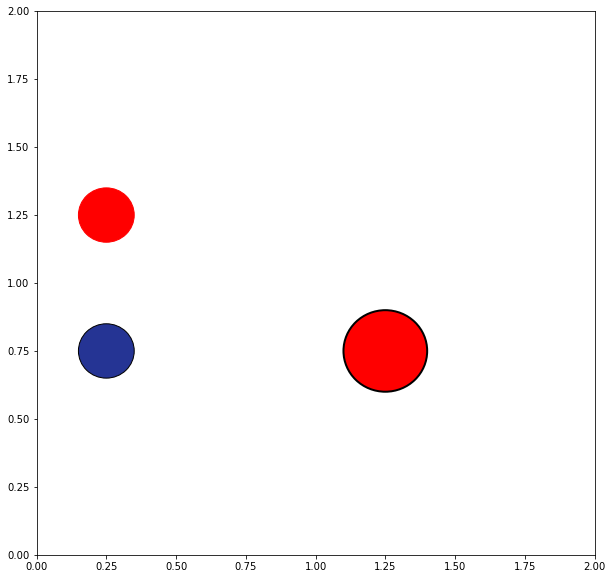

In [37]:
env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
env._render()
print(env._get_obs()['o_near_a'])
env.step(np.array([[-0.7, 0.8]]))
print(env._get_obs()['o_near_a'])

In [102]:
np.linalg.norm(env.world.agents - env.world.agent_goals, axis=-1).min()

0.0071958924124580406

[ 0.02575789  0.03433699 -0.03602446] [0.10167819 0.10148467 0.1014562 ] [0.05151774 0.05153191 0.05182489] [False False False]
[ 0.02537664 -0.3906802  -0.16739684] [0.10168238 0.10049865 0.10086549] [0.05274827 0.05065941 0.05959797] [False False False]
[-0.03811228  0.01238143 -0.16991347] [0.10143796 0.10178343 0.1017378 ] [0.07015951 0.05065015 0.06138194] [False False False]
[-0.30021524 -0.03714538 -0.08384844] [0.10269368 0.10113221 0.10173213] [0.05345098 0.06448264 0.10018109] [False  True False]
[ 0.08678904 -0.19436118  0.01840203] [0.10099737 0.10092313 0.10107676] [0.10097334 0.05024641 0.10078508] [False  True False]
[-0.03836132 -0.12480352  0.05240849] [0.10092387 0.1010386  0.10231777] [0.10087705 0.05040712 0.10132911] [False  True False]
[-0.01883528 -0.29251087 -0.35448337] [0.10114242 0.10245565 0.07877106] [0.10113312 0.05032849 0.07820255] [False False False]
[ 0.01441216 -0.37635913  0.06917125] [0.10094406 0.1041282  0.10143788] [0.10092657 0.05257009 0.101276

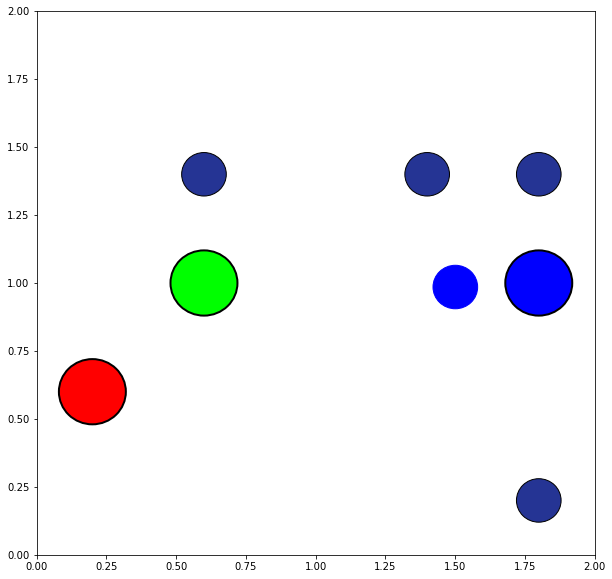

In [49]:
env = MultiPointEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
env.world.obstacles, env.world.agent_goals, env.world.agents = dataset[9]
gifs, collided, done = infer(env, verbose=True)

### visualization on CBF

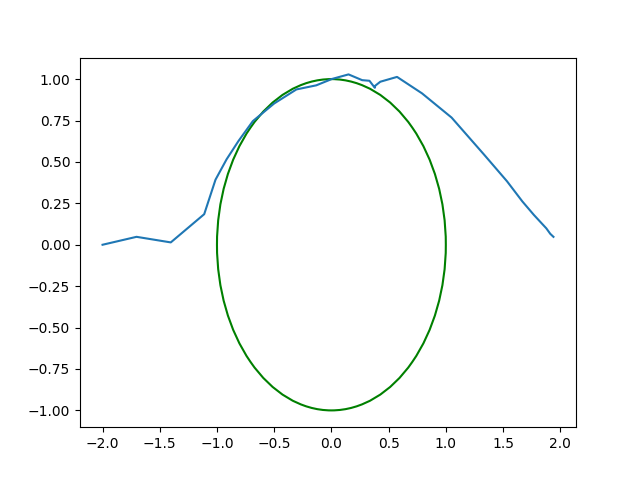

In [30]:
%matplotlib widget
import ipympl
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
fig, ax = plt.subplots()
plt.plot(*np.array(trajs[24]).T)
c = plt.Circle((0, 0), 1, edgecolor='g', facecolor='white', clip_on=False, linewidth=1.5)
ax.add_patch(c)
plt.show()

In [59]:
bnn(x=torch.FloatTensor(np.array(trajs[99])[:-1]).to(device), action=torch.FloatTensor(np.array(trajs[99])[1:,]-np.array(trajs[99])[:-1]).to(device)/0.3).data.cpu().numpy()

array([ 0.00615322,  0.0168369 ,  0.02461939,  0.03725697, -0.04950445,
        0.04675311, -0.01833821,  0.03422268,  0.08368017,  0.09180238,
        0.20361288,  0.3725643 ,  0.5286677 ,  0.6686999 ,  0.7717982 ,
        0.8585829 ,  0.907426  ,  0.94885206,  0.979881  ], dtype=float32)

In [42]:
trajs[59][1]

array([-1.73082578, -0.24192397])

In [133]:
bnn(x=torch.FloatTensor([-1.1, 0]).to(device), action=torch.FloatTensor([0.4, 0]).to(device))

tensor(0.0157, device='cuda:0', grad_fn=<SqueezeBackward1>)

### G

In [37]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 1000
env.reset()
#     env.world.agents = env.world.sample_agents(env.num_agents, prob=0.0)
total_trans=0; n_danger=0; threshold=1e-2

while True:
    o = env._get_obs()
    a_best = nominal_control(o)
    a_other = np.random.uniform(-1., 1., size=(n_candidates-1, env.action_dim))
    a_all = np.zeros((n_candidates, env.action_dim))
    a_all[0, :] = a_best
    a_all[1:, :] = a_other

    o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
    a_refine, bvalue = iter_action(bnn, o, a_other, max_iter=0, threshold=threshold)

    a, a_value = choose_action(a_refine, bvalue, threshold=threshold, explore_eps=0., nominal_eps=0.)

    next_o, rw, done, info = env.step(a_best)
    # if info['next_danger']:
    print(o['x'], a_value)
    n_collide += info['next_danger']

    threshold = 1e-2
    total_trans += 1
    n_danger += np.array(next_danger).sum()

    if done or (total_trans >= max_episode_length):
        n_reach += info['next_goal']
        break

tensor([-2.,  0.]) -0.13107894
tensor([-1.7000,  0.0000]) -0.122936025
tensor([-1.4000,  0.0000]) -0.11164804
tensor([-1.1000,  0.0000]) -0.10055794
tensor([-0.8000,  0.0000]) -0.09046771
tensor([-0.5000,  0.0000]) -0.082239956
tensor([-0.2000,  0.0000]) -0.0731955
tensor([0.1000, 0.0000]) -0.06821193
tensor([0.4000, 0.0000]) -0.07327388
tensor([0.7000, 0.0000]) -0.06384854
tensor([1., 0.]) -0.07175657
tensor([1.3000, 0.0000]) -0.08446115
tensor([1.5100, 0.0000]) -0.08590387
tensor([1.6570, 0.0000]) -0.079477355
tensor([1.7599, 0.0000]) -0.095163316
tensor([1.8319, 0.0000]) -0.08545959
tensor([1.8824, 0.0000]) -0.08211541


# benchmark

In [31]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 100

for _ in tqdm(range(N_TEST)):
    
    infer_traj = [env.reset()]
    total_trans=0; n_danger=0; threshold=2e-2; collided=False
    env.state = env.state + np.random.uniform(-5e-2, 5e-2, size=(2,))

    while True:
        o = env._get_obs()
        a_all = np.hstack([i.reshape(-1, 1) for i in np.meshgrid(*([np.linspace(-1, 1, 20)]*2))])  #np.random.uniform(-1, 1, size=(n_candidates, env.action_dim))

        o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
        a_refine, bvalue = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)

        dists = []
        for a in a_refine:
            next_state = a + env.state
            dists.append(np.linalg.norm(next_state-np.array([2, 0])))
        if np.any(bvalue>threshold):
            for a_idx in np.argsort(dists):
                if bvalue[a_idx] > threshold:
                    a = a_refine[a_idx]
                    break
        else:
            a = a_refine[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)
        infer_traj.append(env.state.copy())
        # if info['next_danger']:
        # print(bvalue[0], bvalue.min(), bvalue.max(), threshold, a_value, 'TRUE' if info['next_danger'] else '')
        if info['next_danger']:
            collided = True
        
        total_trans += 1
        n_danger += np.array(next_danger).sum()

        if done or (total_trans >= max_episode_length):
            n_collide += collided
            n_reach += info['next_goal']
            break

100%|██████████| 100/100 [00:04<00:00, 21.83it/s]


In [32]:
n_collide

0

In [33]:
n_reach

100